In [1]:
from backend.db import DB_PATH
print("DB_PATH =", DB_PATH)


DB_PATH = /home/cvip-titan/sunwoo/ai_docent/met20k/metadata.db


In [2]:
import pandas as pd

df = pd.read_csv("met20k/metadata_with_description.csv")

# met_description 컬럼 기준 필터
df = df[df["met_description"].notna() & (df["met_description"].str.len() > 5)]

df.to_csv("met20k/metadata_filtered.csv", index=False)

print("🎉 필터링 완료: ", len(df))


🎉 필터링 완료:  1719


In [3]:
import sqlite3
import pandas as pd

df = pd.read_csv("met20k/metadata_filtered.csv")

conn = sqlite3.connect("met20k/metadata.db")
df.to_sql("artworks", conn, if_exists="replace", index=False)

conn.close()

print("🎉 SQLite 재생성 완료")


🎉 SQLite 재생성 완료


In [2]:
import sqlite3
import pandas as pd
import os

DB_PATH = "met20k/metadata.db"

CSV_FILES = [
    "met20k/metadata_with_description.csv",
    "met20k/metadata_clip_text.csv"
]

OUTPUT_DIR = "met20k"
    

def get_db_object_ids():
    conn = sqlite3.connect(DB_PATH)
    cur = conn.cursor()

    rows = cur.execute("SELECT objectID FROM artworks").fetchall()

    conn.close()

    # DB 안에 남은 objectID set
    return set([r[0] for r in rows])


def filter_csv(path, valid_ids):
    print(f"\n[처리 중] {path}")

    df = pd.read_csv(path)

    before = len(df)

    # CSV 안에도 objectID가 int형/str형일 수 있으므로 정규화
    df["objectID"] = df["objectID"].astype(int)

    df = df[df["objectID"].isin(valid_ids)]

    after = len(df)

    # 저장 (덮어쓰기)
    df.to_csv(path, index=False)

    print(f"✔ 완료: {before} → {after} 개로 축소됨")


if __name__ == "__main__":
    print("\n===== SQLite DB 기반 objectID 동기화 =====\n")

    valid_ids = get_db_object_ids()
    print(f"DB에 남아있는 objectID 개수: {len(valid_ids)}")

    for csv_path in CSV_FILES:
        filter_csv(csv_path, valid_ids)

    print("\n🎉 모든 CSV가 DB와 동일한 objectID로 동기화 완료!\n")



===== SQLite DB 기반 objectID 동기화 =====

DB에 남아있는 objectID 개수: 1000

[처리 중] met20k/metadata_with_description.csv
✔ 완료: 1719 → 1000 개로 축소됨

[처리 중] met20k/metadata_clip_text.csv
✔ 완료: 2577 → 1000 개로 축소됨

🎉 모든 CSV가 DB와 동일한 objectID로 동기화 완료!



In [3]:
import os
import sqlite3

DB_PATH = "met20k/metadata.db"
IMG_DIR = "met20k/images"

def load_valid_ids():
    conn = sqlite3.connect(DB_PATH)
    rows = conn.execute("SELECT objectID FROM artworks").fetchall()
    conn.close()
    return set(str(r[0]) for r in rows)


def clean_images():
    valid_ids = load_valid_ids()
    print(f"📌 DB에 남아있는 objectID 개수: {len(valid_ids)}")

    images = os.listdir(IMG_DIR)

    removed = 0
    kept = 0

    for file in images:
        if not file.lower().endswith(".jpg"):
            continue

        obj_id = file.replace(".jpg", "")

        if obj_id in valid_ids:
            kept += 1
        else:
            # 삭제
            os.remove(os.path.join(IMG_DIR, file))
            removed += 1

    print("\n===== 이미지 정리 결과 =====")
    print(f"✔ 남긴 이미지: {kept}")
    print(f"🗑 삭제된 이미지: {removed}")
    print("==========================\n")


if __name__ == "__main__":
    clean_images()


📌 DB에 남아있는 objectID 개수: 1000

===== 이미지 정리 결과 =====
✔ 남긴 이미지: 1000
🗑 삭제된 이미지: 1577



In [1]:
import sqlite3
import os

# Notebook에서는 __file__ 이 없음 → 현재 작업 디렉토리를 기준으로 계산
BASE_DIR = os.getcwd()   # 현재 작업 디렉토리
print("Current working directory:", BASE_DIR)

# metadata.db를 찾을 때 상위 폴더에 있을 가능성이 높기 때문에 재조정
# 보통 구조: ai_docent/met20k/metadata.db
if "ai_docent" not in BASE_DIR:
    # Notebook이 backend/나 rag/아닌 위치에서 실행 중이라면 직접 경로 맞춰주기
    BASE_DIR = os.path.join(BASE_DIR, "sunwoo", "ai_docent")

DB_PATH = os.path.join(BASE_DIR, "met20k", "metadata.db")

def inspect_sqlite(db_path):
    if not os.path.exists(db_path):
        print("[ERROR] DB not found:", db_path)
        return
    
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()

    print("\n=== [Tables in DB] ===")
    cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = [row[0] for row in cur.fetchall()]

    if not tables:
        print("No tables found.")
        return

    for table in tables:
        print(f"\n▶ Table: {table}")
        cur.execute(f"PRAGMA table_info({table});")
        columns = cur.fetchall()

        print("  Columns:")
        for col in columns:
            _, name, dtype, *_ = col
            print(f"    - {name} ({dtype})")

    conn.close()


print("DB_PATH =", DB_PATH)
inspect_sqlite(DB_PATH)


Current working directory: /Users/jangsunwoo/Documents/ai_docent
DB_PATH = /Users/jangsunwoo/Documents/ai_docent/met20k/metadata.db

=== [Tables in DB] ===

▶ Table: artworks
  Columns:
    - objectID (INTEGER)
    - title (TEXT)
    - artistDisplayName (TEXT)
    - artistDisplayBio (TEXT)
    - objectDate (TEXT)
    - medium (TEXT)
    - department (TEXT)
    - primaryImage (TEXT)
    - localImagePath (TEXT)
    - met_description (TEXT)
    - description_catalog (TEXT)
    - description_technical (TEXT)


In [1]:
import sqlite3
import pandas as pd

# === DB 파일 경로 확인 ===
# 너의 프로젝트 기준으로 DB 파일이 어디 있는지 설정해줘
DB_PATH = "./met20k/metadata.db"   # 경로 다르면 변경

object_id = 435570

# === DB 읽기 ===
conn = sqlite3.connect(DB_PATH)

query = f"""
SELECT 
    objectID,
    title,
    artistDisplayName,
    met_description
FROM artworks
WHERE objectID = {object_id};
"""

df = pd.read_sql_query(query, conn)
conn.close()

df


,objectID,title,artistDisplayName,met_description
0,435570,A Ship in a Stormy Sea,Ivan Konstantinovich Aivazovsky (Hovhannes Aiv...,Aivazovsky was a celebrated painter of seascap...


In [4]:
import sqlite3
import csv
import os

DB_PATH = "met20k/metadata.db"
CSV_PATH = "met20k/metadata_with_description.csv"

def migrate():
    if not os.path.exists(DB_PATH):
        print(f"❌ DB 파일 없음: {DB_PATH}")
        return

    if not os.path.exists(CSV_PATH):
        print(f"❌ CSV 파일 없음: {CSV_PATH}")
        return

    conn = sqlite3.connect(DB_PATH)
    cur = conn.cursor()

    print("📌 CSV 읽는 중...")

    updated = 0
    with open(CSV_PATH, "r", encoding="utf-8") as f:
        reader = csv.DictReader(f)

        # CSV에 따라 컬럼명 자동 감지
        # met_description / description / desc_catalog 등 여러 가능성을 대비
        possible_cols = ["met_description", "description", "desc", "desc_catalog", "description_catalog"]
        csv_desc_col = None
        for col in possible_cols:
            if col in reader.fieldnames:
                csv_desc_col = col
                break

        if csv_desc_col is None:
            print("❌ CSV에 description 계열 컬럼이 없습니다.")
            return

        print(f"✨ 감지된 설명 컬럼: {csv_desc_col}")

        for row in reader:
            oid = (row.get("objectID") or "").strip()
            desc = (row.get(csv_desc_col) or "").strip()

            if not oid:
                continue

            cur.execute(
                "UPDATE artworks SET met_description = ? WHERE objectID = ?",
                (desc, oid)
            )

            updated += cur.rowcount

    conn.commit()
    conn.close()

    print(f"✅ 업데이트 완료! {updated}개 row 갱신됨")


if __name__ == "__main__":
    migrate()


📌 CSV 읽는 중...
✨ 감지된 설명 컬럼: met_description
✅ 업데이트 완료! 1000개 row 갱신됨


In [14]:
import os
from pathlib import Path
import json
import torch
import faiss
from PIL import Image
from torchvision import transforms
from transformers import CLIPModel, CLIPProcessor
from peft import PeftModel
import numpy as np

# -----------------------------
# PATH CONFIG
# -----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

BASE_CLIP_DIR = "/home/cvip-titan/sunwoo/ai_docent/clip_base"
ZERO_INDEX_DIR = "./index_assets"
LORA_INDEX_DIR = "./index_assets_lora"
LORA_DIR = "./clip_lora"

IMAGE_ROOT = Path("./met20k/images")   # 실제 이미지 폴더


# -----------------------------
# INDEX LOADING
# -----------------------------
def load_index(index_dir):
    index = faiss.read_index(str(Path(index_dir) / "images.faiss"))
    with open(Path(index_dir) / "paths.json", "r") as f:
        paths = json.load(f)
    return index, paths


# -----------------------------
# EMBED
# -----------------------------
@torch.no_grad()
def embed(model, processor, img):
    inputs = processor(images=img, return_tensors="pt").to(DEVICE)
    feat = model.get_image_features(**inputs)
    feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu().numpy().astype("float32")


def load_img(path):
    return Image.open(path).convert("RGB")


# -----------------------------
# PATH NORMALIZER
# -----------------------------
def extract_path(entry):
    """
    Zero-shot = str: 'met20k/images/000.jpg'
    LoRA     = dict: {'path': 'met20k/images/000.jpg', 'objectID':...}

    이 함수는 둘 다 filename만 추출해서
    실제 존재하는 경로 IMAGE_ROOT/filename 로 반환한다.
    """
    if isinstance(entry, str):
        filename = Path(entry).name
    else:
        filename = Path(entry["path"]).name

    real = IMAGE_ROOT / filename

    if not real.exists():
        raise FileNotFoundError(f"Image not found: {real}")

    return str(real)


# -----------------------------
# GET TOP-1
# -----------------------------
def get_top1_image_path(model, processor, index, paths, img):
    q = embed(model, processor, img)
    D, I = index.search(q, 1)
    top_idx = I[0][0]
    return extract_path(paths[top_idx])


# -----------------------------
# STRONG AUGMENTATION
# -----------------------------
def get_augmented_strong(img):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224, scale=(0.25, 1.0)),
        transforms.RandomRotation(25),
        transforms.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6),
        transforms.GaussianBlur(kernel_size=5, sigma=(1.0, 3.0)),
        transforms.RandomAffine(
            degrees=20, translate=(0.25, 0.25),
            scale=(0.6, 1.3), shear=15
        ),
        transforms.RandomPerspective(distortion_scale=0.6, p=1.0)
    ])
    return transform(img)


# -----------------------------
# CONCAT IMAGE
# -----------------------------
def concat_images(img_paths, save_path):
    imgs = [Image.open(p).resize((400, 400)) for p in img_paths]
    widths = sum(i.width for i in imgs)
    canvas = Image.new("RGB", (widths, imgs[0].height))
    x = 0
    for im in imgs:
        canvas.paste(im, (x, 0))
        x += im.width
    canvas.save(save_path)
    print(f"[Saved] {save_path}")


# -----------------------------
# FIND HARD NEGATIVES
# -----------------------------
def find_hard_negative_images(
    zero_model, zero_proc, zero_index, zero_paths,
    lora_model, lora_proc, lora_index, lora_paths,
    sample_size=60
):
    all_imgs = sorted(IMAGE_ROOT.glob("*.jpg"))
    np.random.shuffle(all_imgs)
    subset = all_imgs[:sample_size]

    hard_cases = []

    for p in subset:
        original = load_img(p)
        aug = get_augmented_strong(original)

        zero_top1 = get_top1_image_path(zero_model, zero_proc, zero_index, zero_paths, aug)
        lora_top1 = get_top1_image_path(lora_model, lora_proc, lora_index, lora_paths, aug)

        # 정답 path
        true_path = str(p)

        if zero_top1 != true_path and lora_top1 == true_path:
            hard_cases.append({
                "query": true_path,
                "zero_wrong": zero_top1,
                "lora_correct": lora_top1
            })

    return hard_cases


# -----------------------------
# MAIN FUNCTION
# -----------------------------
def qualitative_example(output_path="qualitative_final.jpg"):
    print("\n=== Loading Models ===")

    zero_model = CLIPModel.from_pretrained(BASE_CLIP_DIR).to(DEVICE).eval()
    zero_proc = CLIPProcessor.from_pretrained(BASE_CLIP_DIR)
    zero_index, zero_paths = load_index(ZERO_INDEX_DIR)

    base = CLIPModel.from_pretrained(BASE_CLIP_DIR).to(DEVICE)
    lora_model = PeftModel.from_pretrained(base, LORA_DIR).to(DEVICE).eval()
    lora_proc = CLIPProcessor.from_pretrained(BASE_CLIP_DIR)
    lora_index, lora_paths = load_index(LORA_INDEX_DIR)

    print("Searching for hard-negative examples...")

    hard = find_hard_negative_images(
        zero_model, zero_proc, zero_index, zero_paths,
        lora_model, lora_proc, lora_index, lora_paths,
        sample_size=80
    )

    if not hard:
        print("⚠ No hard-negative found. Try increasing augmentation or sample_size.")
        return

    case = hard[0]
    print("\n[FOUND HARD CASE]")
    print(case)

    concat_images(
        [case["query"], case["zero_wrong"], case["lora_correct"]],
        output_path
    )


# -----------------------------
# RUN
# -----------------------------
if __name__ == "__main__":
    qualitative_example("qualitative_final.jpg")



=== Loading Models ===
Searching for hard-negative examples...


IndexError: list index out of range

In [3]:
import json

with open("./index_assets_lora/paths.json") as f:
    paths = json.load(f)

print(type(paths))
print(paths[0])


<class 'list'>
{'path': 'met20k/images/435570.jpg', 'objectID': 435570}


In [6]:
import json

with open("index_assets/paths.json", "r") as f:
    zero_paths = json.load(f)

with open("index_assets_lora/paths.json", "r") as f:
    lora_paths = json.load(f)

print("ZERO:", type(zero_paths[0]), zero_paths[0])
print("LORA:", type(lora_paths[0]), lora_paths[0])


ZERO: <class 'str'> met20k/images/390423.jpg
LORA: <class 'dict'> {'path': 'met20k/images/435570.jpg', 'objectID': 435570}


In [11]:
import json
from pathlib import Path

def clean_paths_json(index_dir, image_root):
    paths_file = Path(index_dir) / "paths.json"
    with open(paths_file, "r") as f:
        raw = json.load(f)

    image_root = Path(image_root)
    cleaned = []
    missing = []

    for entry in raw:
        # Zero-shot: entry = "met20k/images/xxxx.jpg"
        # LoRA: entry = {"path": "...", "objectID": ...}
        if isinstance(entry, str):
            img_path = image_root / Path(entry).name
            if img_path.exists():
                cleaned.append(entry)
            else:
                missing.append(entry)

        elif isinstance(entry, dict):
            img_path = image_root / Path(entry["path"]).name
            if img_path.exists():
                cleaned.append(entry)
            else:
                missing.append(entry)

    # 저장
    with open(paths_file, "w") as f:
        json.dump(cleaned, f, indent=2)

    print("\n=== CLEAN COMPLETE ===")
    print(f"Total original: {len(raw)}")
    print(f"Total cleaned : {len(cleaned)}")
    print(f"Missing files : {len(missing)}")

    if missing:
        print("Missing examples:")
        for m in missing[:10]:
            print("  ", m)

    return cleaned, missing


if __name__ == "__main__":
    # Zero-shot index 정리
    clean_paths_json("./index_assets", "./met20k/images")

    # LoRA index 정리
    clean_paths_json("./index_assets_lora", "./met20k/images")



=== CLEAN COMPLETE ===
Total original: 2577
Total cleaned : 1000
Missing files : 1577
Missing examples:
   met20k/images/390423.jpg
   met20k/images/437857.jpg
   met20k/images/437909.jpg
   met20k/images/438839.jpg
   met20k/images/437205.jpg
   met20k/images/436424.jpg
   met20k/images/437423.jpg
   met20k/images/335273.jpg
   met20k/images/345101.jpg
   met20k/images/437876.jpg

=== CLEAN COMPLETE ===
Total original: 1000
Total cleaned : 1000
Missing files : 0


In [13]:
import random
from PIL import Image
import numpy as np
from torchvision import transforms

def make_aug():
    return transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
        transforms.RandomRotation(10),
        transforms.ColorJitter(0.2,0.2,0.2,0.1)
    ])

def qualitative_batch(n=5, save_dir="./qual"):
    os.makedirs(save_dir, exist_ok=True)
    aug = make_aug()

    samples = random.sample(sorted(IMAGE_DIR.glob("*.jpg")), n)
    for i, p in enumerate(samples):
        query = Image.open(p).convert("RGB")
        aug_q = aug(query)

        zero_top = get_top1_image_path(zero_model, zero_proc, zero_index, zero_paths, aug_q)
        lora_top = get_top1_image_path(lora_model, lora_proc, lora_index, lora_paths, aug_q)

        if int(Path(zero_top).stem) == int(p.stem):
            continue  # zero-shot 맞추면 의미 없음

        if int(Path(lora_top).stem) != int(p.stem):
            continue  # LoRA도 틀리면 qualitative 의미 없음

        concat_images([str(p), zero_top, lora_top],
                      f"{save_dir}/case_{i+1}.jpg")

    print("=== qualitative saved ===")


In [15]:
import os
import json
import faiss
import torch
import numpy as np
from pathlib import Path
from PIL import Image
from transformers import CLIPModel, CLIPProcessor

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

BASE_MODEL = "/home/cvip-titan/sunwoo/ai_docent/clip_base"
IMAGE_DIR = Path("./met20k/images")
SAVE_DIR = "./index_assets_zero"

os.makedirs(SAVE_DIR, exist_ok=True)

model = CLIPModel.from_pretrained(BASE_MODEL).to(DEVICE).eval()
proc = CLIPProcessor.from_pretrained(BASE_MODEL)

@torch.no_grad()
def embed(img):
    x = proc(images=img, return_tensors="pt").to(DEVICE)
    feat = model.get_image_features(**x)
    feat = feat / feat.norm(p=2)
    return feat.cpu().numpy().astype("float32")

paths = sorted(IMAGE_DIR.glob("*.jpg"))
index = faiss.IndexFlatIP(512)

all_paths = []
for p in paths:
    img = Image.open(p).convert("RGB")
    v = embed(img)
    index.add(v)
    all_paths.append({"path": str(p), "objectID": int(p.stem)})

faiss.write_index(index, f"{SAVE_DIR}/images.faiss")

with open(f"{SAVE_DIR}/paths.json", "w") as f:
    json.dump(all_paths, f, indent=2)

print("=== CLEAN INDEX BUILT ===")
print("Total images:", len(all_paths))


=== CLEAN INDEX BUILT ===
Total images: 1000


In [16]:
import json
from pathlib import Path

ZERO = json.load(open("index_assets/paths.json"))
LORA = json.load(open("index_assets_lora/paths.json"))

def extract_ids(entries):
    ids = []
    for e in entries:
        if isinstance(e, str):
            ids.append(int(Path(e).stem))
        else:
            ids.append(e["objectID"])
    return set(ids)

zero_ids = extract_ids(ZERO)
lora_ids = extract_ids(LORA)

print("Zero count:", len(zero_ids))
print("LORA count:", len(lora_ids))

print("Missing in LORA:", zero_ids - lora_ids)
print("Missing in Zero:", lora_ids - zero_ids)


Zero count: 1000
LORA count: 1000
Missing in LORA: set()
Missing in Zero: set()


In [18]:
import os
import json
import faiss
import torch
import numpy as np
from pathlib import Path
from PIL import Image
from torchvision import transforms
from transformers import CLIPModel, CLIPProcessor
from peft import PeftModel

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

BASE_CLIP_DIR = "/home/cvip-titan/sunwoo/ai_docent/clip_base"
ZERO_INDEX_DIR = "./index_clean"          # 2번에서 rebuild한 Zero-shot 인덱스
LORA_INDEX_DIR = "./index_assets_lora"    # 기존 LoRA 인덱스
LORA_DIR = "./clip_lora"
IMAGE_DIR = Path("./met20k/images")


# ----------------------------------------------------
# LOAD INDEX
# ----------------------------------------------------
def load_index(index_dir):
    index = faiss.read_index(str(Path(index_dir) / "images.faiss"))
    with open(Path(index_dir) / "paths.json") as f:
        paths = json.load(f)
    return index, paths


# ----------------------------------------------------
# EMBEDDING
# ----------------------------------------------------
@torch.no_grad()
def embed(model, processor, img):
    x = processor(images=img, return_tensors="pt").to(DEVICE)
    feat = model.get_image_features(**x)
    feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu().numpy().astype("float32")


def load_img(path):
    return Image.open(path).convert("RGB")


def extract_path(entry):
    if isinstance(entry, str):
        return entry
    return entry["path"]


def get_top1(model, proc, index, paths, img):
    q = embed(model, proc, img)
    D, I = index.search(q, 1)
    return extract_path(paths[I[0][0]])


# ----------------------------------------------------
# STRONG AUGMENTATION
# ----------------------------------------------------
def get_aug(img):
    tfm = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224, scale=(0.25, 1.0)),
        transforms.RandomRotation(25),
        transforms.ColorJitter(.6, .6, .6),
        transforms.GaussianBlur(5, sigma=(1, 3)),
        transforms.RandomPerspective(p=1.0, distortion_scale=0.6)
    ])
    return tfm(img)


# ----------------------------------------------------
# FIND HARD-NEGATIVE SAMPLES
# ----------------------------------------------------
def find_hard_negative_images(zero_model, zero_proc, zero_index, zero_paths,
                              lora_model, lora_proc, lora_index, lora_paths,
                              sample_size=50):

    imgs = list(IMAGE_DIR.glob("*.jpg"))
    np.random.shuffle(imgs)
    imgs = imgs[:sample_size]

    hard_cases = []

    for p in imgs:
        true_path = str(p)
        img = load_img(true_path)
        aug = get_aug(img)

        z_top1 = get_top1(zero_model, zero_proc, zero_index, zero_paths, aug)
        l_top1 = get_top1(lora_model, lora_proc, lora_index, lora_paths, aug)

        if z_top1 != true_path and l_top1 == true_path:
            hard_cases.append({
                "query": true_path,
                "zero_wrong": z_top1,
                "lora_correct": l_top1
            })

    return hard_cases


# ----------------------------------------------------
# CONCAT
# ----------------------------------------------------
def concat_images(paths, save_path):
    imgs = [Image.open(p).resize((400, 400)) for p in paths]
    W = sum(i.width for i in imgs)
    H = imgs[0].height
    canvas = Image.new("RGB", (W, H))
    x = 0
    for im in imgs:
        canvas.paste(im, (x, 0))
        x += im.width
    canvas.save(save_path)
    print("[Saved]", save_path)


# ----------------------------------------------------
# MAIN
# ----------------------------------------------------
def qualitative_example(output="qual_final.jpg"):

    print("Loading Zero-shot CLIP...")
    zero_model = CLIPModel.from_pretrained(BASE_CLIP_DIR).to(DEVICE).eval()
    zero_proc = CLIPProcessor.from_pretrained(BASE_CLIP_DIR)
    zero_index, zero_paths = load_index(ZERO_INDEX_DIR)

    print("Loading LoRA CLIP...")
    base = CLIPModel.from_pretrained(BASE_CLIP_DIR).to(DEVICE)
    lora_model = PeftModel.from_pretrained(base, LORA_DIR).to(DEVICE).eval()
    lora_proc = CLIPProcessor.from_pretrained(BASE_CLIP_DIR)
    lora_index, lora_paths = load_index(LORA_INDEX_DIR)

    print("Searching for cases where Zero-shot fails but LoRA succeeds...")
    hard = find_hard_negative_images(
        zero_model, zero_proc, zero_index, zero_paths,
        lora_model, lora_proc, lora_index, lora_paths,
        sample_size=80
    )

    if len(hard) == 0:
        print("No hard-negative samples found.")
        return

    case = hard[0]
    print("FOUND:", case)

    concat_images(
        [case["query"], case["zero_wrong"], case["lora_correct"]],
        output
    )


if __name__ == "__main__":
    qualitative_example("qualitative_final.jpg")


Loading Zero-shot CLIP...
Loading LoRA CLIP...
Searching for cases where Zero-shot fails but LoRA succeeds...
No hard-negative samples found.


In [19]:
import os
import json
import faiss
import torch
import numpy as np
from pathlib import Path
from PIL import Image
from transformers import CLIPModel, CLIPProcessor
from torchvision import transforms
from peft import PeftModel

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

BASE_CLIP = "/home/cvip-titan/sunwoo/ai_docent/clip_base"
ZERO_INDEX = "./index_clean"                 # Zero-shot clean index
LORA_INDEX = "./index_assets_lora"           # LoRA index (기존)
LORA_DIR = "./clip_lora"

IMAGE_DIR = Path("./met20k/images")


# ============================================================
# Index Loader
# ============================================================
def load_index(path):
    index = faiss.read_index(str(Path(path) / "images.faiss"))
    with open(Path(path) / "paths.json", "r") as f:
        paths = json.load(f)
    return index, paths


# ============================================================
# Embedding
# ============================================================
@torch.no_grad()
def embed(model, processor, img):
    x = processor(images=img, return_tensors="pt").to(DEVICE)
    feat = model.get_image_features(**x)
    feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu().numpy().astype("float32")


def extract_path(entry):
    if isinstance(entry, str):
        return entry
    return entry["path"]


def get_top1(model, proc, index, paths, img):
    q = embed(model, proc, img)
    D, I = index.search(q, 1)
    idx = I[0][0]
    return extract_path(paths[idx])


# ============================================================
# Controlled Augmentation (between aug=2 and aug=3 intensity)
# ============================================================
def custom_aug(img):
    tf = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224, scale=(0.45, 1.0)),   # aug2~3 middle
        transforms.RandomRotation(12),
        transforms.ColorJitter(brightness=0.4, contrast=0.4),
        transforms.GaussianBlur(kernel_size=3, sigma=(0.5, 1.5)),
        transforms.RandomAffine(
            degrees=12, translate=(0.15, 0.15), scale=(0.75, 1.2)
        ),
    ])
    return tf(img)


# ============================================================
# Create 3-column qualitative figure
# ============================================================
def concat_images(paths, save_path):
    imgs = [Image.open(p).resize((400, 400)) for p in paths]

    W = sum(im.width for im in imgs)
    H = imgs[0].height

    canvas = Image.new("RGB", (W, H))
    x = 0
    for im in imgs:
        canvas.paste(im, (x, 0))
        x += im.width

    canvas.save(save_path)
    print(f"[Saved] {save_path}")


# ============================================================
# Hard-negative Finder
# ============================================================
def find_hard_cases(zero_m, zero_p, zero_i, zero_paths,
                    lora_m, lora_p, lora_i, lora_paths,
                    max_samples=300):

    imgs = sorted(list(IMAGE_DIR.glob("*.jpg")))
    np.random.shuffle(imgs)
    imgs = imgs[:max_samples]

    hard_list = []

    for img_path in imgs:
        img = Image.open(img_path).convert("RGB")
        aug = custom_aug(img)
        true_path = str(img_path)

        # predictions
        z_top = get_top1(zero_m, zero_p, zero_i, zero_paths, aug)
        l_top = get_top1(lora_m, lora_p, lora_i, lora_paths, aug)

        # hard negative 조건
        if z_top != true_path and l_top == true_path:
            hard_list.append({
                "query": true_path,
                "zero_wrong": z_top,
                "lora_correct": l_top
            })

            # 하나만 찾으면 바로 종료
            return hard_list

    return hard_list


# ============================================================
# MAIN
# ============================================================
def run(output="qualitative_hard.jpg"):
    print("Loading Zero-shot...")
    zero_m = CLIPModel.from_pretrained(BASE_CLIP).to(DEVICE).eval()
    zero_p = CLIPProcessor.from_pretrained(BASE_CLIP)
    zero_i, zero_paths = load_index(ZERO_INDEX)

    print("Loading LoRA CLIP...")
    base = CLIPModel.from_pretrained(BASE_CLIP).to(DEVICE)
    lora_m = PeftModel.from_pretrained(base, LORA_DIR).to(DEVICE).eval()
    lora_p = CLIPProcessor.from_pretrained(BASE_CLIP)
    lora_i, lora_paths = load_index(LORA_INDEX)

    print("Searching hard-negatives (zero wrong, lora correct)...")

    hard = find_hard_cases(
        zero_m, zero_p, zero_i, zero_paths,
        lora_m, lora_p, lora_i, lora_paths,
        max_samples=350
    )

    if len(hard) == 0:
        print("⚠ No hard cases found. Try increasing augmentation intensity.")
        return

    case = hard[0]
    print("Found hard case:", case)

    concat_images(
        [case["query"], case["zero_wrong"], case["lora_correct"]],
        output
    )


if __name__ == "__main__":
    run("qualitative_hard.jpg")


Loading Zero-shot...
Loading LoRA CLIP...
Searching hard-negatives (zero wrong, lora correct)...
⚠ No hard cases found. Try increasing augmentation intensity.


In [12]:
# =============================
# 0. 공통 준비 코드
# =============================
import os
import json
import torch
import faiss
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from transformers import CLIPModel, CLIPProcessor
from peft import PeftModel

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

BASE_CLIP_DIR = "/home/cvip-titan/sunwoo/ai_docent/clip_base"
LORA_DIR = "./clip_lora"
ZERO_INDEX_DIR = "./index_assets"
LORA_INDEX_DIR = "./index_assets_lora"

IMAGE_DIR = Path("./met20k/images")

def load_index(index_dir):
    index = faiss.read_index(str(Path(index_dir) / "images.faiss"))
    with open(Path(index_dir) / "paths.json", "r") as f:
        paths = json.load(f)
    return index, paths


print("Loading Zero-shot CLIP...")
zero_model = CLIPModel.from_pretrained(BASE_CLIP_DIR).to(DEVICE).eval()
zero_proc  = CLIPProcessor.from_pretrained(BASE_CLIP_DIR)
zero_index, zero_paths = load_index(ZERO_INDEX_DIR)

print("Loading LoRA CLIP...")
base_model = CLIPModel.from_pretrained(BASE_CLIP_DIR).to(DEVICE)
lora_model = PeftModel.from_pretrained(base_model, LORA_DIR).to(DEVICE).eval()
lora_proc  = CLIPProcessor.from_pretrained(BASE_CLIP_DIR)
lora_index, lora_paths = load_index(LORA_INDEX_DIR)


@torch.no_grad()
def embed(model, processor, img):
    x = processor(images=img, return_tensors="pt").to(DEVICE)
    feat = model.get_image_features(**x)
    feat = feat / feat.norm(p=2)
    return feat.cpu().numpy().astype("float32")


def extract_path(entry):
    if isinstance(entry, str):
        return entry
    return entry["path"]


def get_topk(model, proc, index, paths, img, k=5):
    q = embed(model, proc, img)
    D, I = index.search(q, k)
    results = []
    for idx in I[0]:
        results.append(extract_path(paths[idx]))
    return results, D[0]


/home/cvip-titan/ENTER/envs/aidocent/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading Zero-shot CLIP...


/home/cvip-titan/ENTER/envs/aidocent/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loading LoRA CLIP...


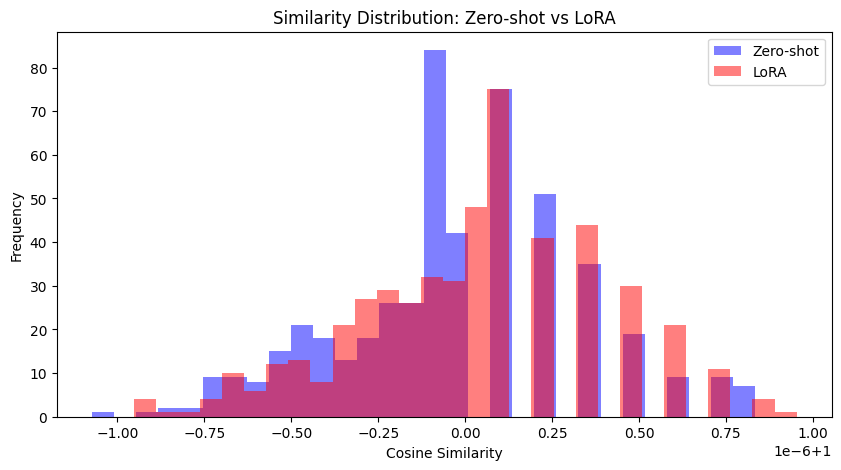

In [2]:
# =============================
# 1. Similarity Distribution Plot
# =============================
import random

N = 500
samples = random.sample(list(IMAGE_DIR.glob("*.jpg")), N)

zero_sims = []
lora_sims = []

for img_path in samples:
    img = Image.open(img_path).convert("RGB")

    # Zero-shot
    q = embed(zero_model, zero_proc, img)
    D, I = zero_index.search(q, 1)
    zero_sims.append(float(D[0][0]))

    # LoRA
    q2 = embed(lora_model, lora_proc, img)
    D2, I2 = lora_index.search(q2, 1)
    lora_sims.append(float(D2[0][0]))

# Histogram plot
plt.figure(figsize=(10,5))
plt.hist(zero_sims, bins=30, alpha=0.5, label='Zero-shot', color='blue')
plt.hist(lora_sims, bins=30, alpha=0.5, label='LoRA', color='red')
plt.legend()
plt.title("Similarity Distribution: Zero-shot vs LoRA")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()


In [13]:
# =============================
# 2. Top-5 Ranking Visualization
# =============================
from PIL import Image, ImageDraw  # ← Image 추가!

import random

IMAGE_DIR = Path("/home/cvip-titan/sunwoo/ai_docent/met20k/images")

query_img_path = random.choice(list(IMAGE_DIR.glob("*.jpg")))
query_img = Image.open(query_img_path).convert("RGB")

zero_top5, zero_scores = get_topk(zero_model, zero_proc, zero_index, zero_paths, query_img, k=5)
lora_top5, lora_scores = get_topk(lora_model, lora_proc, lora_index, lora_paths, query_img, k=5)

print("[Query]", query_img_path)
print("[Zero-shot Top5]")
for i, (p, s) in enumerate(zip(zero_top5, zero_scores)):
    print(f"  {i+1}. {p}  (sim={s:.4f})")

print("\n[LoRA Top5]")
for i, (p, s) in enumerate(zip(lora_top5, lora_scores)):
    print(f"  {i+1}. {p}  (sim={s:.4f})")


def make_strip(img_paths, save_path):
    imgs = [Image.open(p).resize((300,300)) for p in img_paths]
    canvas = Image.new("RGB", (300*len(imgs), 300))
    x = 0
    for im in imgs:
        canvas.paste(im, (x,0))
        x += 300
    canvas.save(save_path)

make_strip([query_img_path] + zero_top5, "zero_top5_strip.jpg")
make_strip([query_img_path] + lora_top5, "lora_top5_strip.jpg")

print("Saved:")
print(" - zero_top5_strip.jpg")
print(" - lora_top5_strip.jpg")


[Query] /home/cvip-titan/sunwoo/ai_docent/met20k/images/435755.jpg
[Zero-shot Top5]
  1. met20k/images/435755.jpg  (sim=1.0000)
  2. met20k/images/441965.jpg  (sim=0.9079)
  3. met20k/images/437891.jpg  (sim=0.9071)
  4. met20k/images/437180.jpg  (sim=0.9054)
  5. met20k/images/816618.jpg  (sim=0.9010)

[LoRA Top5]
  1. met20k/images/435755.jpg  (sim=1.0000)
  2. met20k/images/441965.jpg  (sim=0.9086)
  3. met20k/images/437891.jpg  (sim=0.9076)
  4. met20k/images/437180.jpg  (sim=0.9058)
  5. met20k/images/816618.jpg  (sim=0.9022)
Saved:
 - zero_top5_strip.jpg
 - lora_top5_strip.jpg


In [11]:
print("Zero index:", zero_index.ntotal, "paths:", len(zero_paths))
print("LORA index:", lora_index.ntotal, "paths:", len(lora_paths))


Zero index: 2577 paths: 1000
LORA index: 1000 paths: 1000


In [2]:
print("Zero index:", zero_index.ntotal, "paths:", len(zero_paths))
print("LORA index:", lora_index.ntotal, "paths:", len(lora_paths))


NameError: name 'zero_index' is not defined

In [1]:
print("Zero index:", zero_index.ntotal, "paths:", len(zero_paths))


NameError: name 'zero_index' is not defined

In [14]:
import os
print("Reading zero index from:", os.path.abspath(ZERO_INDEX_DIR))


Reading zero index from: /home/cvip-titan/sunwoo/ai_docent/index_assets


In [5]:
import json, faiss
from pathlib import Path

ZERO_INDEX_DIR = "./index_assets"
LORA_INDEX_DIR = "./index_assets_lora"

def load_index(index_dir):
    index = faiss.read_index(str(Path(index_dir) / "images.faiss"))
    with open(Path(index_dir) / "paths.json", "r") as f:
        paths = json.load(f)
    return index, paths


zero_index, zero_paths = load_index(ZERO_INDEX_DIR)
lora_index, lora_paths = load_index(LORA_INDEX_DIR)

print("Zero index:", zero_index.ntotal, "paths:", len(zero_paths))
print("LORA index:", lora_index.ntotal, "paths:", len(lora_paths))


Zero index: 1000 paths: 1000
LORA index: 1000 paths: 1000


In [14]:
# =============================
# 3. Robustness to Augmentation
# =============================
import torchvision.transforms as T

augmentations = [
    T.Compose([T.Resize((224,224))]),  # aug0
    T.Compose([T.Resize((224,224)), T.ColorJitter(0.3,0.3,0.3)]),  # aug1
    T.Compose([T.Resize((224,224)), T.RandomRotation(20), T.ColorJitter(0.4,0.4,0.4)]),  # aug2
    T.Compose([
        T.Resize((224,224)),
        T.RandomResizedCrop(224, scale=(0.3,1.0)),
        T.RandomRotation(30),
        T.ColorJitter(0.5,0.5,0.5),
        T.GaussianBlur(5)
    ])  # aug3
]

query_path = random.choice(list(IMAGE_DIR.glob("*.jpg")))
original = Image.open(query_path).convert("RGB")

print("Query:", query_path)

for i, aug in enumerate(augmentations):
    aug_img = aug(original)

    zero_top1, _ = get_topk(zero_model, zero_proc, zero_index, zero_paths, aug_img, k=1)
    lora_top1, _ = get_topk(lora_model, lora_proc, lora_index, lora_paths, aug_img, k=1)

    print(f"\n=== Aug level {i} ===")
    print("Zero-shot:", zero_top1[0])
    print("LoRA     :", lora_top1[0])

    # Save augmented image for side-by-side
    aug_img.save(f"aug_{i}.jpg")

print("\nAugmented images saved as aug_0.jpg ... aug_3.jpg")


Query: /home/cvip-titan/sunwoo/ai_docent/met20k/images/436554.jpg

=== Aug level 0 ===
Zero-shot: met20k/images/436554.jpg
LoRA     : met20k/images/436554.jpg

=== Aug level 1 ===
Zero-shot: met20k/images/436554.jpg
LoRA     : met20k/images/436554.jpg

=== Aug level 2 ===
Zero-shot: met20k/images/436554.jpg
LoRA     : met20k/images/436554.jpg

=== Aug level 3 ===
Zero-shot: met20k/images/435725.jpg
LoRA     : met20k/images/435725.jpg

Augmented images saved as aug_0.jpg ... aug_3.jpg


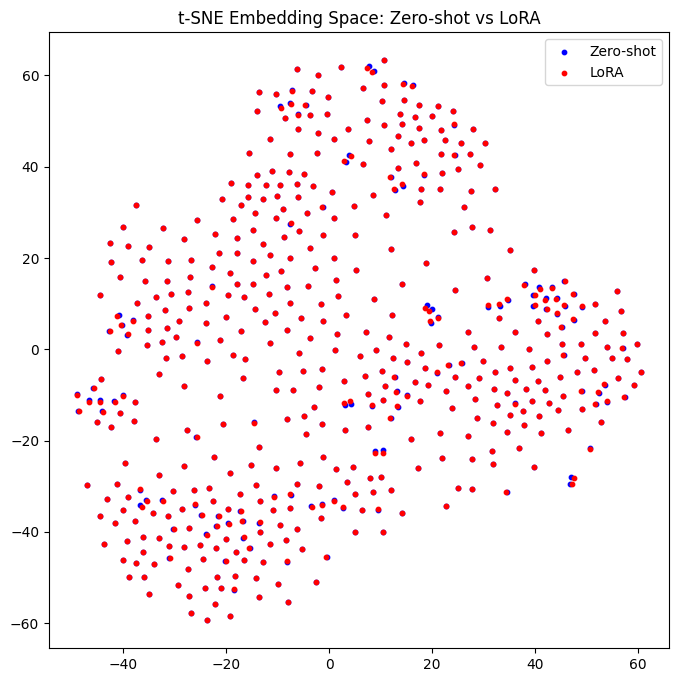

In [16]:
import random
import numpy as np
from pathlib import Path
from PIL import Image
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# -------------------------------
# 🔧 embed_model 함수 추가 (중요)
# -------------------------------
@torch.no_grad()
def embed_model(model, processor, img):
    x = processor(images=img, return_tensors="pt").to(DEVICE)
    feat = model.get_image_features(**x)
    feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu().numpy().astype("float32")

# -------------------------------

SAMPLE = 500
img_paths = random.sample(list(IMAGE_DIR.glob("*.jpg")), SAMPLE)

zero_feats = []
lora_feats = []

for p in img_paths:
    img = Image.open(p).convert("RGB")
    zero_feats.append(embed_model(zero_model, zero_proc, img))
    lora_feats.append(embed_model(lora_model, lora_proc, img))

zero_feats = np.vstack(zero_feats)
lora_feats = np.vstack(lora_feats)

all_feats = np.vstack([zero_feats, lora_feats])
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_2d = tsne.fit_transform(all_feats)

z_2d = tsne_2d[:SAMPLE]
l_2d = tsne_2d[SAMPLE:]

plt.figure(figsize=(8,8))
plt.scatter(z_2d[:,0], z_2d[:,1], c='blue', s=10, label="Zero-shot")
plt.scatter(l_2d[:,0], l_2d[:,1], c='red', s=10, label="LoRA")
plt.legend()
plt.title("t-SNE Embedding Space: Zero-shot vs LoRA")
plt.savefig("tsne_compare.jpg", dpi=200)
plt.show()


In [17]:
false_zero = []
false_lora = []

for p in img_paths[:300]:
    img = Image.open(p).convert("RGB")
    true_path = str(p)

    zero_t1 = get_top1(zero_model, zero_proc, zero_index, zero_paths, img)
    lora_t1 = get_top1(lora_model, lora_proc, lora_index, lora_paths, img)

    if zero_t1 != true_path and lora_t1 == true_path:
        false_zero.append((true_path, zero_t1))
    if lora_t1 != true_path and zero_t1 == true_path:
        false_lora.append((true_path, lora_t1))

print("Zero-shot Wrong but LoRA Correct:", len(false_zero))
print("LoRA Wrong but Zero-shot Correct:", len(false_lora))


NameError: name 'get_top1' is not defined